In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

Cookie Cats - чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедините три», в которой игрок должен соединять плитки одного цвета, чтобы очистить поле и выиграть уровень. 

<p style="align: center;"><img align=center src="https://i.ytimg.com/vi/iPxZIp0cbJE/maxresdefault.jpg"  width=500></p>
 
 
<p style="align: center;"><img align=center src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png"  width=500></p>


По мере прохождения уровней игры игроки время от времени сталкиваются с воротами, которые заставляют их ждать некоторое количество времени или совершать покупки в приложении, чтобы продолжить. Помимо стимулирования покупок в приложении, эти ворота служат важной цели - дать игрокам вынужденный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия от игры.

<b>Но где ставить ворота? </b>
Первоначально первые ворота были размещены на уровне 30. В этом проекте вам предлагается проанализировать AB-тест, в котором создатели переместили первые ворота в Cookie Cats с 30 уровня на уровень 40. В частности, вам надо рассмотрим влияние A/B теста на удержание игроков.

### Данные A/B тестирования

In [3]:
data = pd.read_csv('cookie_cats.csv', on_bad_lines='skip')  
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


**Данные получены от 90 189 игроков, которые установили игру во время проведения AB-теста. Переменные:**

* `userid` - уникальный номер, идентифицирующий каждого игрока.

* `version` - был ли игрок помещен в контрольную группу (gate_30 - ворота на уровне 30) или в тестовую группу (gate_40 - ворота на уровне 40).

* `sum_gamerounds` - количество игровых раундов, сыгранных игроком в течение первой недели после установки
* `retention_1` - игрок вернулся и поиграл через 1 день после установки?
* `retention_7` - игрок вернулся и играл через 7 дней после установки?

Когда игрок устанавливал игру, ему случайным образом назначали `gate_30` или `gate_40`.

<b>Задача: провести анализ данных и сделать выводы о лучшем месте для установки ворот.</b>

In [4]:
# Посмотрим на количество участников теста.
data.groupby('version').version.count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

In [5]:
data.groupby('version').sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222944098441,2344795,20034,8502
gate_40,227857702576,2333530,20119,8279


In [6]:
data.groupby('version').mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.987564e+06,52.456264,0.448188,0.190201
gate_40,5.009073e+06,51.298776,0.442283,0.182000


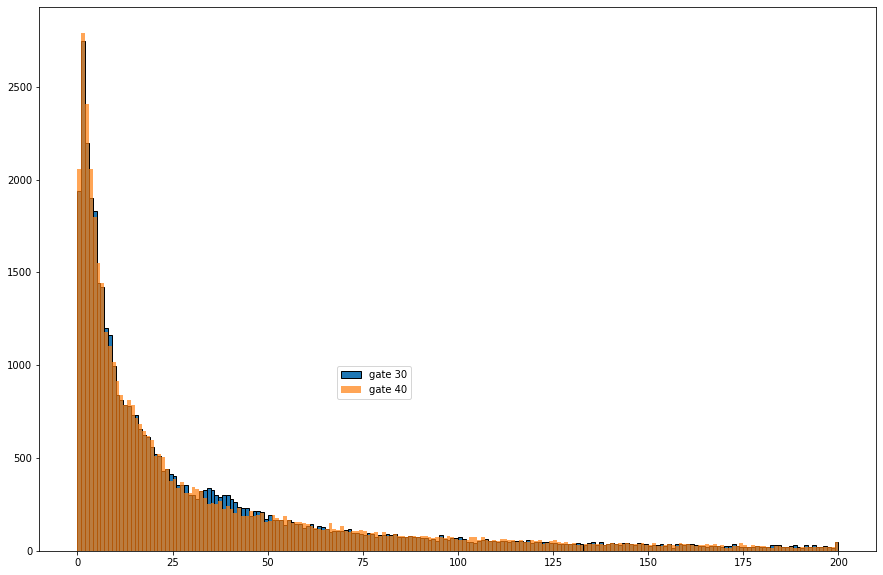

In [7]:
v_30 = data.loc[data.version == 'gate_30']
v_40 = data.loc[data.version == 'gate_40']
v_30 = v_30.drop(v_30.loc[v_30.sum_gamerounds > 200].index)
v_40 = v_40.drop(v_40.loc[v_40.sum_gamerounds > 200].index)


bins = 200
plt.figure(figsize=(15, 10))
plt.hist(v_30['sum_gamerounds'], bins=bins, alpha=1,
         edgecolor='black', label='gate 30')
plt.hist(v_40['sum_gamerounds'], bins=bins, alpha=0.7, label='gate 40')
plt.legend(loc='upper right', bbox_to_anchor=(0.45, 0.35))
plt.show()

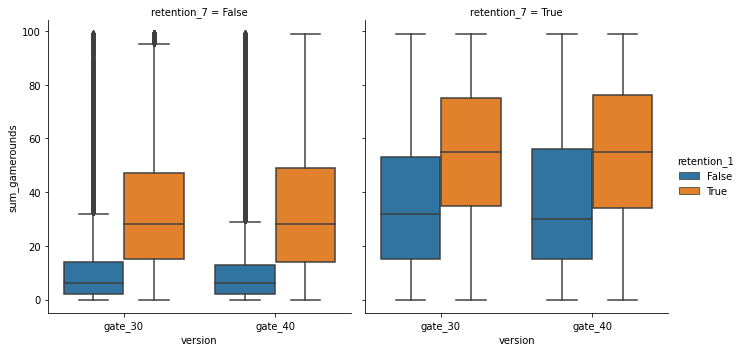

In [8]:
df = data.loc[data['sum_gamerounds'] < 100].copy();

sns.catplot(x="version", y="sum_gamerounds",
            hue="retention_1", col = 'retention_7',
            data=df, kind="box",
            height=5, aspect=.95);


Н0 - распределения одинаковы

In [9]:
from scipy.stats import mannwhitneyu
import scipy.stats as stats

stat, p = mannwhitneyu(data[data['version'] == 'gate_30']['sum_gamerounds'], data[data['version'] == 'gate_40']['sum_gamerounds'])

print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')


Статистика=1024331250.500, p=0.050
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


Применяем Bootstrap для того, чтобы более наглядно убедиться в наличии различий

<Figure size 1080x720 with 0 Axes>

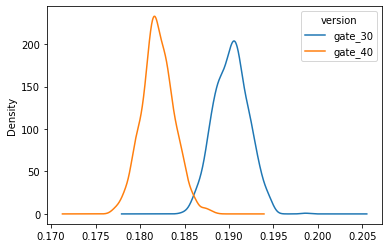

In [10]:
plt.figure(figsize=(15, 10))
# boot_1d - собираем статистику по средним, для неё можно применить t-тест
boot_1d = []
for i in range(1000):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_1d.append(boot_mean)

# Преобразование списка в DataFrame
boot_1d = pd.DataFrame(boot_1d)

# График полученного распределения
boot_1d.plot(kind='density')

Прежде чем использовать t-тест, необходимо проверить равенство дисперссий. Сделаем это с помощью <a href="https://ru.wikipedia.org/wiki/F-%D1%82%D0%B5%D1%81%D1%82">F-теста</a>. Используем собстенную функцию. 

Н0 - дисперсии выборок одинаковы

In [11]:
def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-st.f.cdf(f, nun, dun)
    return f, p_value

In [12]:
stat, p = f_test(boot_1d['gate_30'], boot_1d['gate_40'])

print('Статистика=%.3f, p=%.5f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, дисперссии, вероятно, различаются')

Статистика=1.091, p=0.08381
Не отклоняем нулевую гипотезу, дисперссии, вероятно, одинаковые


Теперь можно использовать t-критерий 

Н0 - средние выборок одинаковы

In [ ]:
stat, p = st.ttest_ind(boot_1d['gate_30'], boot_1d['gate_40'])
print('Статистика=%.3f, p=%.5f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=100.132, p=0.00000
Отклоняем нулевую гипотезу, средние, вероятно, различаются


<b>Выводы.</b> Наше значение $p$ близко к нулю, поэтому мы отвергаем нулевую гипотезу о том, что средние значения двух выборок одинаковые. То есть существует статистически значимая разница между тем где поставить ворота!